In [1]:
# import required libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import time

# Import mlcompute module to use the optional set_mlc_device API for device selection with ML Compute.
from tensorflow.python.compiler.mlcompute import mlcompute

# Select processing device.
mlcompute.set_mlc_device(device_name='gpu') # Available options are 'cpu', 'gpu', and 'any'.

# Remove apple to tensorflow comparison warnings
# note these warning do not affect the model, they are removed for visual purposes
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
# measure time taken for model to run and to run image technique
start = time.time()

In [3]:
# download dataset and initialise test/train
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
# apply image technique to dataset
hough_train = np.empty((50000, 32, 32, 3))
hough_test = np.empty((10000, 32, 32, 3))

# convert image to gray, canny edge with 255/2 to 255 then save to hough a colour
for index, image in enumerate(train_images):
    gray = cv.cvtColor((image * 255).astype(np.uint8), cv.COLOR_BGR2GRAY)
    canny = cv.Canny(gray, 255/2, 255, None, 3)
    hough_train[index] = cv.cvtColor(canny, cv.COLOR_GRAY2BGR)
    
    # probalistic Hough Line Transform
    linesP = cv.HoughLinesP(canny, 1, np.pi / 180, 50, None, 50, 10)
    
    # Draw the lines
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv.line(hough_train[index], (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
            
for index, image in enumerate(test_images):
    gray = cv.cvtColor((image * 255).astype(np.uint8), cv.COLOR_BGR2GRAY)
    canny = cv.Canny(gray, 255/2, 255, None, 3)
    hough_test[index] = cv.cvtColor(canny, cv.COLOR_GRAY2BGR)
    
    # probalistic Hough Line Transform
    linesP = cv.HoughLinesP(canny, 1, np.pi / 180, 50, None, 50, 10)
    
    # Draw the lines
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv.line(hough_test[index], (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

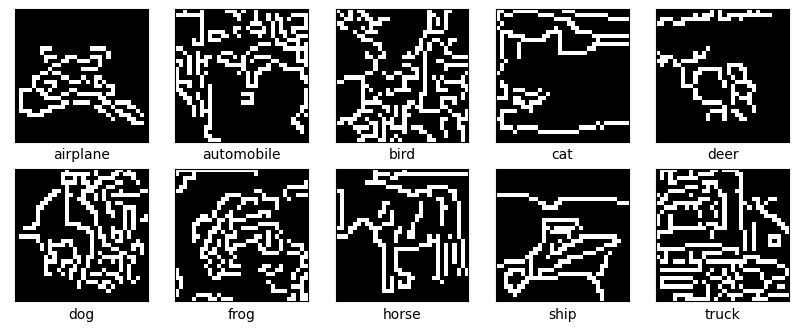

In [5]:
# verify data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

image_class_index = [hough_train[30], hough_train[5], hough_train[6], hough_train[9], hough_train[3],
                     hough_train[27], hough_train[0], hough_train[7], hough_train[8], hough_train[1]]

plt.figure(figsize=(10,10))
for i in range(len(image_class_index)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_class_index[i].astype('uint8'), cmap='gray')
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[i])
plt.show()

In [6]:
# import model
model = models.load_model("CNN")

# compile and train model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'], run_eagerly=False)

history = model.fit(hough_train, train_labels, epochs=10, 
                    validation_data=(hough_test, test_labels))

end = time.time()

Epoch 1/10
1563/1563 [==============================] - 55s 34ms/step - loss: 4.5189 - accuracy: 0.3015 - val_loss: 1.5523 - val_accuracy: 0.4567
Epoch 2/10
1563/1563 [==============================] - 54s 34ms/step - loss: 1.4271 - accuracy: 0.5013 - val_loss: 1.4252 - val_accuracy: 0.5016
Epoch 3/10
1563/1563 [==============================] - 53s 34ms/step - loss: 1.2903 - accuracy: 0.5518 - val_loss: 1.4150 - val_accuracy: 0.5131
Epoch 4/10
1563/1563 [==============================] - 53s 34ms/step - loss: 1.1523 - accuracy: 0.5995 - val_loss: 1.4182 - val_accuracy: 0.5137
Epoch 5/10
1563/1563 [==============================] - 54s 34ms/step - loss: 1.0411 - accuracy: 0.6351 - val_loss: 1.4722 - val_accuracy: 0.5049
Epoch 6/10
1563/1563 [==============================] - 53s 34ms/step - loss: 0.8935 - accuracy: 0.6927 - val_loss: 1.5410 - val_accuracy: 0.5020
Epoch 7/10
1563/1563 [==============================] - 53s 34ms/step - loss: 0.7486 - accuracy: 0.7403 - val_loss: 1.6406 -

Validation set results
313/313 - 4s - loss: 2.0442 - accuracy: 0.4972
Total time taken to classify: 9.04 minutes


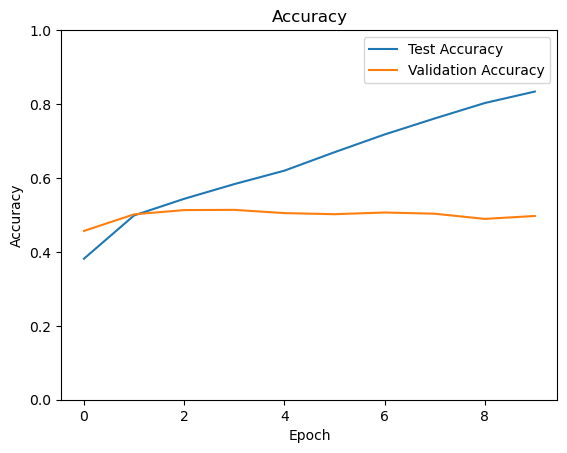

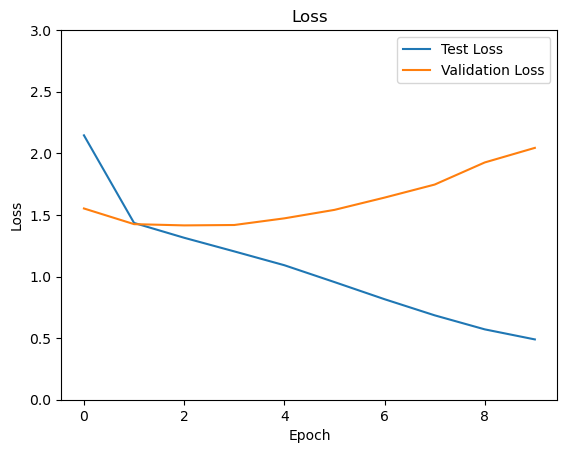

In [8]:
# test model and print results
print("Validation set results")
test_loss, test_acc = model.evaluate(hough_test, test_labels, verbose = 2)

# print total time take
minutes = (end - start) / 60
print("Total time taken to classify: {:.2f}".format(minutes), "minutes")

# Plot the accuracy
plt.title("Accuracy")
plt.plot(history.history['accuracy'], label='Test Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.show()

# Plot the loss
plt.title("Loss")
plt.plot(history.history['loss'], label='Test Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='upper right')
plt.show()